In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import brier_score_loss
from itertools import cycle


In [2]:
results =  [Path(x).name for x in glob.glob('../data/SpineNet_results_all_probabilities/*.csv')]  # '../../rwindsor1_SpineNet/results/*.csv'

In [3]:
dfs = []
for i in results:
    df = pd.read_csv(f'../data/SpineNet_results_all_probabilities/{i}')  # ../../rwindsor1_SpineNet/results/
    df['project_ID'] = i[:-4]
    dfs.append(df)

df = pd.concat(dfs)
df.columns.values[0] = "Level"
    

In [4]:
gt_pf = pd.read_csv('../data/p0741_c6646c_dd_konsensus.csv')

# Convert from wide to long:
gt_pf = pd.melt(gt_pf, id_vars= ["project_ID"], value_vars=["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"], 
               var_name = "Level",
              value_name = "gt_pf")



In [5]:
mcs = pd.read_csv('../data/DD_variables.csv')
mcs['Level'] = mcs['Level'].str.replace('_','-')
mcs = mcs[['project_ID', 'Level', 'Rostral_MC_type', 'Caudal_MC_type']]
mcs['Rostral_MC_type'] = np.where(mcs['Rostral_MC_type'] != 0, 1, mcs['Rostral_MC_type'])
mcs['Caudal_MC_type'] = np.where(mcs['Caudal_MC_type'] != 0, 1, mcs['Caudal_MC_type'])




In [6]:
dfx = pd.merge(df, gt_pf, on = ['project_ID', 'Level'], how='left')
dfx = pd.merge(dfx, mcs, on = ['project_ID', 'Level'], how = 'left')

In [7]:
# Remove irrelevant levels:
dfx = dfx.loc[dfx['Level'].isin(["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"])]

# Select the level:
# dfx = dfx.loc[dfx['Level'] == 'L2-L3']

# Claening up the dataframe:
# Replace 1 predictions with 2 to match Finnish data:
dfx['Pfirrmann'] = dfx["Pfirrmann"].replace(1, 2)

# dfx = dfx.dropna(subset=['gt_pf'])

# sum the Pfirrmann class 1 and 2 probabilities
sum_column = dfx["Pfirrmann_probability_1"] + dfx["Pfirrmann_probability_2"]
dfx["Pfirrmann_probability_2"] = sum_column


In [8]:
# fill in the gaps for Pfirrmann grade

missing = dfx.loc[dfx['gt_pf'].isna()]
missing = missing[['project_ID', 'Level']]

# get PFirrmann grade for these project IDs
replacements = pd.read_csv('../data/DD_variables.csv')
# Correct a mismatch in the level name format:
replacements['Level'] = replacements['Level'].str.replace('_','-')
replacements = replacements[['project_ID', 'Level', 'Pfirrmann_grade']]

# Find those available in replacements that are missing:
x = pd.merge(missing, replacements, on = ['project_ID', 'Level'], how='left')

dfx = pd.merge(dfx, x, on = ['project_ID', 'Level'], how='left')

dfx['gt_pf'] = dfx['gt_pf'].fillna(dfx['Pfirrmann_grade'])

dfx = dfx.dropna(subset=['gt_pf'])
dfx = dfx.dropna(subset=['Rostral_MC_type'])
dfx = dfx.dropna(subset=['Caudal_MC_type'])

# def a(row):
#     val = None
#     if row['Rostral_MC_type'] != row['UpperMarrow']:
#         val = 1 - row['UpperMC_probability']
#     else:
#         val = row['UpperMC_probability']

#     return val

# dfx['UpperMC_probabilities_all'] = dfx.apply(a, axis=1)

# def b(row):
#     val = None
#     if row['Caudal_MC_type'] != row['LowerMarrow']:
#         val = 1 - row['LowerMC_probability']
#     else:
#         val = row['LowerMC_probability']

#     return val

# dfx['LowerMC_probabilities_all'] = dfx.apply(b, axis=1)

def a(row):
    val = None
    if row['Rostral_MC_type'] == row['UpperMarrow']:
        val = 1 
    else:
        val = 0

    return val

dfx['UpperMC_correct'] = dfx.apply(a, axis=1)

def b(row):
    val = None
    if row['Caudal_MC_type'] == row['LowerMarrow']:
        val = 1 
    else:
        val = 0

    return val

dfx['LowerMC_correct'] = dfx.apply(b, axis=1)

dfx

# Fill them back in

,Level,Pfirrmann,Pfirrmann_probability,Pfirrmann_probability_1,Pfirrmann_probability_2,Pfirrmann_probability_3,Pfirrmann_probability_4,Pfirrmann_probability_5,Narrowing,CentralCanalStenosis,...,ForaminalStenosisLeft,ForaminalStenosisRight,Herniation,project_ID,gt_pf,Rostral_MC_type,Caudal_MC_type,Pfirrmann_grade,UpperMC_correct,LowerMC_correct
0,L1-L2,2,0.615105,0.381507,0.996612,0.003381,0.000004,0.000003,1,1,...,0,0,0,P0741_10043,2.0,0.0,0.0,NaN,1,1
1,L2-L3,2,0.631919,0.631919,0.967838,0.032060,0.000069,0.000032,1,1,...,0,0,0,P0741_10043,3.0,0.0,0.0,NaN,1,1
2,L3-L4,3,0.785057,0.002528,0.016957,0.785057,0.195788,0.002198,3,1,...,0,0,1,P0741_10043,4.0,1.0,1.0,NaN,1,1
3,L4-L5,5,0.992305,0.000012,0.000018,0.000513,0.007163,0.992305,4,1,...,1,1,1,P0741_10043,5.0,1.0,1.0,NaN,1,1
4,L5-S1,5,0.961743,0.000002,0.000006,0.000578,0.037672,0.961743,4,1,...,1,1,1,P0741_10043,5.0,1.0,1.0,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,L1-L2,2,0.641660,0.142212,0.783872,0.214848,0.001273,0.000007,1,1,...,0,0,0,P0741_9968,2.0,0.0,0.0,NaN,1,1
1815,L2-L3,5,0.666351,0.000034,0.000129,0.013277,0.320242,0.666351,4,2,...,1,1,1,P0741_9968,5.0,1.0,1.0,NaN,1,1
1816,L3-L4,4,0.592904,0.001032,0.003763,0.388292,0.592904,0.015041,3,2,...,1,1,1,P0741_9968,4.0,0.0,1.0,NaN,0,1
1817,L4-L5,4,0.835423,0.000127,0.000706,0.103902,0.835423,0.059969,3,2,...,1,1,1,P0741_9968,4.0,1.0,1.0,NaN,1,1


In [9]:
dfx.to_csv('test.csv')

In [10]:

dfx = dfx[~dfx['gt_pf'].isin(['?'])]
dfx["gt_pf"] = pd.to_numeric(dfx["gt_pf"])

C:\Users\tmcsween21\AppData\Local\Temp\ipykernel_33540\1289121902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["gt_pf"] = pd.to_numeric(dfx["gt_pf"])


In [11]:
dfx.to_csv('df.csv')

Balanced accuracy: 
0.783319255698288
Brier score: 
0.1032823409084466
Brier score: 
0.14987213738583513
Brier score: 
0.06628482053707643
Brier score: 
0.018268527884376915


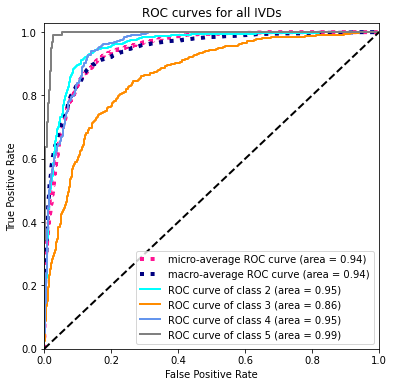

In [21]:
#### ROC for Pfirrmann grades ####
levels = ["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"]
# for j in levels:
df = dfx
# df = df.loc[df['Level'] == j]
y_test = df[['gt_pf']].to_numpy()
y_prediction = df[['Pfirrmann']].to_numpy()

print('Balanced accuracy: ')
print(balanced_accuracy_score(y_test, y_prediction))

y_test = label_binarize(y_test, classes=[2, 3, 4, 5])
y_prediction = label_binarize(y_prediction, classes=[2, 3, 4, 5])
n_classes = y_test.shape[1]



y_prob = df[["Pfirrmann_probability_2", "Pfirrmann_probability_3", "Pfirrmann_probability_4", "Pfirrmann_probability_5"]].to_numpy()

for i in range(n_classes):
    # print(balanced_accuracy_score(y_test[:, i], y_prediction[:, i]))
    print('Brier score: ')
    print(brier_score_loss(y_test[:, i], y_prob[:, i]))

fpr = dict()
tpr = dict()
roc_auc = dict()
for k in range(n_classes):
    fpr[k], tpr[k], _ = roc_curve(y_test[:, k], y_prob[:, k])
    roc_auc[k] = auc(fpr[k], tpr[k])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#### For single ROC plot ####
lw = 2
# for i in range(n_classes):
#     plt.figure()
#     lw = 2
#     plt.plot(
#         fpr[i],
#         tpr[i],
#         color="darkorange",
#         lw=lw,
#         label="ROC curve (area = %0.2f)" % roc_auc[i],
#     )
#     plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC for class {i+2} at level {j}")
#     plt.legend(loc="lower right")
#     plt.show()

#### For overlaid ROC plots ####
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6, 6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "grey"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+2, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves for all IVDs")
plt.legend(loc="lower right")
plt.show()

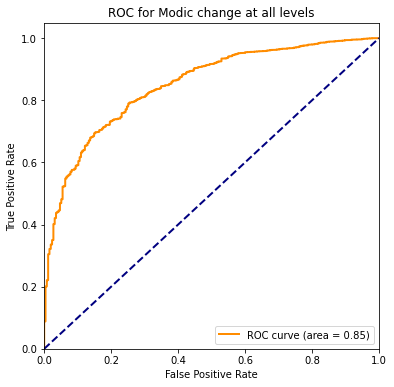

In [14]:
#### ROC for upper Modic changes ####
levels = ["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"]
dfx = pd.read_csv('../scripts/test.csv')
# for j in levels:
df = dfx
# df = df.loc[df['Level'] == j]
y_test = df[['UpperMC_correct']].to_numpy()
y_prediction = df[['UpperMarrow']].to_numpy()
# print(y_test)
# print(y_prediction)
# y_test = label_binarize(y_test, classes=[0, 1])
# y_prediction = label_binarize(y_prediction, classes=[2, 3, 4, 5])
# n_classes = y_test.shape[1]

# for i in range(n_classes):
# print('Balanced accuracy: ')
# print(balanced_accuracy_score(y_test, y_prediction))

y_prob = df[["UpperMC_probability"]].to_numpy()
# print('Brier score: ')
# print(brier_score_loss(y_test, y_prob))

# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for k in range(n_classes):
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#### For single ROC plot ####
# for i in range(n_classes):
plt.figure(figsize=(6,6))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC for Modic change at all levels")
plt.legend(loc="lower right")
plt.show()


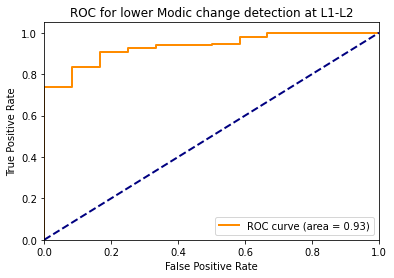

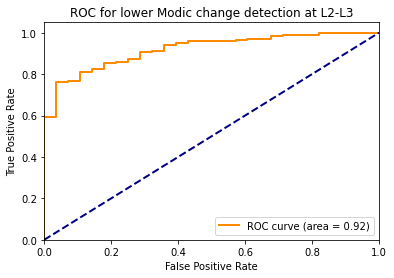

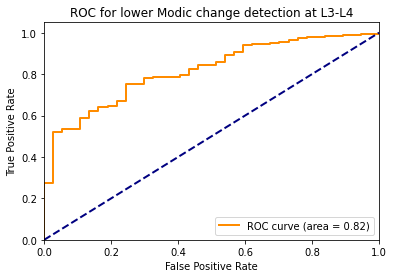

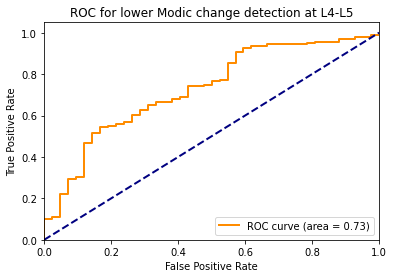

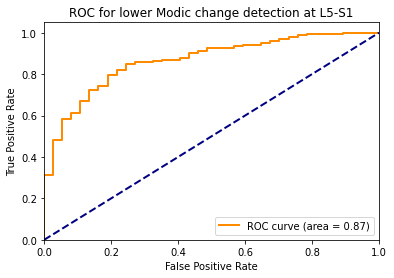

In [14]:
#### ROC for lower Modic changes ####
levels = ["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"]
for j in levels:
    df = dfx
    df = df.loc[df['Level'] == j]
    y_test = df[['LowerMC_correct']].to_numpy()
    y_prediction = df[['LowerMarrow']].to_numpy()
    # print(y_test)
    # print(y_prediction)
    # y_test = label_binarize(y_test, classes=[2, 3, 4, 5])
    # y_prediction = label_binarize(y_prediction, classes=[2, 3, 4, 5])
    # n_classes = y_test.shape[1]

    # for i in range(n_classes):
    # print('Balanced accuracy: ')
    # print(balanced_accuracy_score(y_test, y_prediction))
    

    y_prob = df[["LowerMC_probability"]].to_numpy()
    # print('Brier score: ')
    # print(brier_score_loss(y_test, y_prob))

    # fpr = dict()
    # tpr = dict()
    # roc_auc = dict()
    # for k in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #### For single ROC plot ####
    # for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC for lower Modic change detection at {j}")
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# levels = ["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"]
# for j in levels:

#     df = pd.read_csv('df.csv')
#     df = df.loc[df['Level'] == j]
#     gt = df[['gt']].to_numpy()
#     probs = df[['probs']].to_numpy()
#     fpr, tpr, _ = roc_curve(gt, probs)
#     roc_auc = auc(fpr, tpr)

#     plt.figure()
#     lw = 2
#     plt.plot(
#         fpr,
#         tpr,
#         color="darkorange",
#         lw=lw,
#         label="ROC curve (area = %0.2f)" % roc_auc,
#     )
#     plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC for Modic change detection at {j}.")
#     plt.legend(loc="lower right")
#     plt.show()

